PPCA lavora con più variabili osservabili anzichè una sola

In [39]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import aesara.tensor as at
import arviz as az
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import scipy
import pandas as pd

In [40]:
scaler = StandardScaler()

# extract data social anxiety

In [41]:
csv_ = '/Users/marcoghezzi/PycharmProjects/pythonProject/osfstorage-archive/behavior/LookAtMe_045.csv'
csv_ = '/home/paolo/matteo/matteo/unimi/tesi_master/code/osfstorage-archive/behavior/LookAtMe_045.csv'
global_data = pd.read_csv(csv_, sep='\t')
y = np.array(list([int(d>2) for d in global_data['rating']]))
e_labels = y[:,np.newaxis]  # rating > 2

In [42]:
print(len(e_labels))

160


In [43]:
N_e = e_labels.shape[0]
D_e = e_labels.shape[1]
print(N_e,D_e)

160 1


## test with new data

In [44]:
from deepemogp import feature_extractor
from deepemogp.signal import physio as physio
from deepemogp import datasets as datasets
from deepemogp.signal import behavior as behavior
from deepemogp.signal.physio import ecg
# from: https://github.com/SheffieldML/GPy
#import GPy
# from: https://github.com/SheffieldML/PyDeepGP
#import deepgp

import pandas as pd
import numpy as np

show = False
# definition of the feature extractors to be used later
f2 = feature_extractor.FE('wavelet', window=(2, 1))
f3 = feature_extractor.FE('mean', window=(1,0))

# definition of the physiological signals to be extracted
eda_ = physio.EDA(f2)
hr_ = physio.HR(f2)
pupil_ = behavior.PUPIL(f3)

# definition of the emotional annotation to be extracted
#va = annotation.VA('valence', f3)
#ar = annotation.VA('arousal', f3)
# extraction of the desired data from the dataset
d = datasets.FEAR(signals={hr_,pupil_,eda_}, subjects={'45'})

for s in d.signals:
    # preprocess ...
    if s.name =='EDA':
        s.preprocess(show=show,new_fps=500)
        s.feature_ext.extract_feat(s,show=show)
    else:
        if s.name == 'HR':
            list_hr_test = s.raw[0]['data']
            s.preprocess(show=show, useneurokit=True)
            s.feature_ext.extract_feat(s,show=show)

        else:
            s.feature_ext.extract_feat_without_preprocess(s, show=show)

    #add feature extraction for eda before preprocessing

    # ... and extract features from each signal type


for sig in d.signals:
    if sig.name=='EDA':
        eda_data = sig.features
    if sig.name=='HR':
        hr_data = sig.features
    if sig.name=='PUPIL':
        pupil_data = sig.features

>> Loading PUPIL for subject 45 and all sessions from dataset FEAR
>> Loading HR for subject 45 and all sessions from dataset FEAR
>> Loading EDA for subject 45 and all sessions from dataset FEAR
>> Extracting mean features from PUPIL signal, adopting (1, 0) window ...
>> Processing HR ... using neurokit


/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/n

>> Extracting wavelet features from HR signal, adopting (2, 1) window ...
>> Processing EDA ...
>> Extracting wavelet features from EDA signal, adopting (2, 1) window ...


In [45]:
list(d.signals)[1].name

'HR'

In [46]:
#list(d.signals)[1].processed[159]['data']

In [47]:
np.array(eda_data)

array([[ 0.21089198,  0.21299844,  0.18295063, ..., 18.06615451,
        26.96868488, 32.85239766],
       [ 2.78544979,  2.78724221,  2.78544259, ..., 36.3720917 ,
        35.32808967, 33.59990245],
       [33.0967512 , 33.09537987, 33.05058977, ..., 28.71642892,
        26.01996046, 23.65914786],
       ...,
       [-0.09779168, -0.09761474, -0.09886241, ...,  4.60282338,
         4.47246627,  4.25476926],
       [ 4.18185862,  4.18168447,  4.17597989, ...,  3.51597365,
         4.20735397,  7.71553228],
       [ 4.24299733,  4.24296692,  4.24412082, ..., 29.59908028,
        44.23850683, 52.36256189]])

In [48]:
np.array(hr_data)

array([[1507.82432239, 1507.82432239, 1507.82432239, ..., 1586.03068697,
        1613.1587688 , 1619.89798969],
       [1507.85637107, 1507.82802011, 1508.46636127, ..., 1478.06965461,
        1395.47520837, 1366.4733097 ],
       [1620.04757606, 1620.00004585, 1619.44095792, ..., 1381.13232251,
        1398.42285198, 1420.22660599],
       ...,
       [1469.66722725, 1469.67133663, 1469.75810463, ..., 1682.85176299,
        1701.05552378, 1703.67041282],
       [1619.65487205, 1619.61171622, 1618.93042939, ..., 1556.47535447,
        1487.88118798, 1466.0223053 ],
       [1703.15260394, 1703.11211732, 1702.7560271 , ..., 1445.25223889,
        1441.56087692, 1441.25889603]])

In [49]:
np.array(pupil_data)

array([[2.45239393],
       [2.66638125],
       [2.59187033],
       [2.4506036 ],
       [2.80837978],
       [2.59338696],
       [2.55991296],
       [2.53492629],
       [2.48206472],
       [2.62299583],
       [2.51776189],
       [2.52536855],
       [2.71710262],
       [2.85383682],
       [2.64254111],
       [2.59916026],
       [2.78052864],
       [2.66078013],
       [2.80587036],
       [2.90862783],
       [2.66953859],
       [2.56049477],
       [2.37752592],
       [2.4753718 ],
       [2.82322928],
       [2.69363716],
       [2.60489613],
       [2.52116537],
       [2.56927633],
       [2.71404879],
       [2.53859531],
       [2.63078144],
       [3.00423614],
       [2.67140556],
       [2.65304165],
       [2.45419989],
       [2.29169615],
       [2.40401754],
       [2.40156297],
       [2.46497346],
       [2.7961956 ],
       [2.60416088],
       [2.46037891],
       [2.54203925],
       [2.48787623],
       [2.46366409],
       [2.67486512],
       [2.658

In [50]:
TRIAL = 160

In [51]:
hr =np.array(hr_data)
hr = hr.reshape((TRIAL, int(hr.shape[0]/TRIAL*hr.shape[1])))
hr

array([[1507.82432239, 1507.82432239, 1507.82432239, ..., 1566.0845009 ,
        1520.02818112, 1518.7678512 ],
       [1561.94779093, 1561.94779093, 1561.94779093, ..., 1513.92693106,
        1511.8541424 , 1511.8541424 ],
       [1552.65898888, 1552.65898888, 1552.65898888, ..., 1478.91710429,
        1478.91614366, 1478.91614366],
       ...,
       [1513.53959853, 1513.53959853, 1513.53959853, ..., 1475.70110856,
        1475.70110856, 1475.70110856],
       [1562.66691975, 1562.66691975, 1562.66691975, ..., 1694.83054188,
        1731.68433009, 1731.6894679 ],
       [1539.28006789, 1539.28006789, 1539.28006789, ..., 1445.25223889,
        1441.56087692, 1441.25889603]])

In [52]:
pupil = np.array(pupil_data)
pupil = pupil.reshape((TRIAL, int(pupil.shape[0]/TRIAL*pupil.shape[1])))
pupil

array([[2.45239393, 2.66638125, 2.59187033, 2.4506036 , 2.80837978],
       [2.59338696, 2.55991296, 2.53492629, 2.48206472, 2.62299583],
       [2.51776189, 2.52536855, 2.71710262, 2.85383682, 2.64254111],
       [2.59916026, 2.78052864, 2.66078013, 2.80587036, 2.90862783],
       [2.66953859, 2.56049477, 2.37752592, 2.4753718 , 2.82322928],
       [2.69363716, 2.60489613, 2.52116537, 2.56927633, 2.71404879],
       [2.53859531, 2.63078144, 3.00423614, 2.67140556, 2.65304165],
       [2.45419989, 2.29169615, 2.40401754, 2.40156297, 2.46497346],
       [2.7961956 , 2.60416088, 2.46037891, 2.54203925, 2.48787623],
       [2.46366409, 2.67486512, 2.65886801, 2.5452179 , 2.69123385],
       [2.35282239, 2.51053252, 2.47818746, 2.61634768, 2.34638445],
       [2.69495718, 2.91349163, 3.06015049, 2.77073565, 2.72773236],
       [2.53074146, 2.42715984, 2.60548436, 2.70087583, 2.3135078 ],
       [2.55345281, 2.62065232, 2.58789636, 2.644122  , 2.72449498],
       [2.45065309, 2.5222609 , 2.

In [53]:
eda = np.array(eda_data)
eda = eda.reshape((TRIAL,int(eda.shape[0]/TRIAL*eda.shape[1])))
eda

array([[ 2.10891983e-01,  2.12998437e-01,  1.82950635e-01, ...,
         1.31000424e+01,  1.19876484e+01,  1.09912966e+01],
       [ 4.79881800e-01,  4.84782808e-01,  4.19306285e-01, ...,
         1.70782579e+01,  1.52385652e+01,  1.37090198e+01],
       [-8.62379325e-01, -8.71626109e-01, -7.66350705e-01, ...,
         1.88873483e+01,  1.80621614e+01,  1.71648583e+01],
       ...,
       [-8.87428418e-01, -8.97424247e-01, -8.04640781e-01, ...,
         1.75345145e+01,  2.41071828e+01,  2.83073815e+01],
       [ 1.27413860e+00,  1.28461551e+00,  1.04262039e+00, ...,
         3.05011220e+01,  3.90704780e+01,  4.29526697e+01],
       [-1.25129379e-02, -1.24530688e-02, -5.70494938e-03, ...,
         2.95990803e+01,  4.42385068e+01,  5.23625619e+01]])

## end test

prendo un'implementazione di sppca e la applico al nostro caso

different types of observable data

1) gaze
2) fisio
    2.1) heart rate variability
    2.2) eda phasic value
3) social anxiety
4) aspettativa del dolore

In [54]:

'''social_anx = data['social anxiety'][:,np.newaxis]
pain_exp = data['pain expectation'][:,np.newaxis]'''


"social_anx = data['social anxiety'][:,np.newaxis]\npain_exp = data['pain expectation'][:,np.newaxis]"

In [55]:
print(pupil.shape)
print(hr.shape)
print(eda.shape)

(160, 5)
(160, 60)
(160, 60)


In [56]:
N_pupil = pupil.shape[0]
D_pupil = pupil.shape[1]

N_hr = hr.shape[0]
D_hr = hr.shape[1]

N_eda = eda.shape[0]
D_eda = eda.shape[1]
K = 3

print(N_pupil,D_pupil)
print(N_hr,D_hr)
print(N_eda,D_eda)
print(N_e, D_e)

160 5
160 60
160 60
160 1


In [89]:
with pm.Model(coords={"time": hr}) as sPPCA:
    #dati osservabili
    hr_data = pm.MutableData("hr_data", hr.T)
    pupil_data = pm.MutableData("pupil_data", pupil.T)
    eda_data = pm.MutableData("eda_data", eda.T)

    e_data = pm.ConstantData("e_data", e_labels.T)

    #matrici pesi
    Whr = pm.Normal('Whr', mu=at.zeros([D_hr, K]), sigma=2.0 * at.ones([D_hr, K]), shape=[D_hr, K])
    Wpupil = pm.Normal('Wpupil', mu=at.zeros([D_pupil, K]), sigma=2.0 * at.ones([D_pupil, K]), shape=[D_pupil, K])

    Weda = pm.Normal('Weda', mu=at.zeros([D_eda, K]), sigma=2.0 * at.ones([D_eda, K]), shape=[D_eda, K])

    #weight matrix for pain expectation.
    #check mu,sigma,shape
    We = pm.Normal('W_e', mu=at.zeros([D_e, K]), sigma=2.0 * at.ones([D_e,K]), shape=[D_e, K])

    #latent space
    c = pm.Normal('c', mu=at.zeros([N_hr,K]), sigma=at.ones([N_hr,K]), shape=[N_hr,K])

    # dati dell'hrv interpretati come una gaussiana
    sigma_alpha_hr = pm.Exponential("sigma_alpha", Whr.dot(c.T))
    x_hr = pm.GaussianRandomWalk('x_hr', sigma=sigma_alpha_hr, init_dist=pm.Normal.dist(mu=0,sigma=1),dims = 'time')

    '''
    x_hr = pm.Normal('x_hr', mu=Whr.dot(c.T), sigma=at.ones([D_hr,N_hr]) ,shape=[D_hr, N_hr], observed=hr_data)
    '''

    # dati della dilatazione pupille interpretati come una gaussiana
    x_pupil = pm.Normal('x_pupil', mu=Wpupil.dot(c.T), sigma=at.ones([D_pupil, N_pupil]), shape=[D_pupil, N_pupil], observed=pupil_data)
    #eda
    x_eda = pm.Normal('x_eda',mu=Weda.dot(c.T),sigma= at.ones([D_eda,N_pupil]), shape=[D_eda,N_eda], observed=eda_data)

    # pain expectation. ciò che dovremmo inferire dato c
    # due strade: binary o multiclass (1-4)
    # p = probability of success?
    x_e = pm.Bernoulli('x_e' , p=pm.math.sigmoid(We.dot(c.T)) , shape =[D_e, N_e], observed=e_data)

    #x_hr = pm.Bernoulli('x_hr', p=pm.math.sigmoid(Whr.dot(c.T)), shape=[D_hr, N_hr], observed=hr_data)
    #x_eda = pm.Bernoulli('x_eda', p=pm.math.sigmoid(Weda.dot(c.T)), shape=[D_eda, N_eda], observed=eda_data)

In [90]:
gv = pm.model_to_graphviz(sPPCA)
gv.view()

'.gv.pdf'

In [83]:
sPPCA.free_RVs

[Whr ~ N(f(), f()),
 Wpupil ~ N(f(), f()),
 Weda ~ N(f(), f()),
 W_e ~ N(f(), f()),
 c ~ N(f(), f()),
 sigma_alpha ~ Exp(f()),
 x_hr ~ RandomWalk(N(f(Whr, c), f()), N(0, sigma_alpha), f())]

In [84]:
with sPPCA:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    trace = approx.sample(500)

'''with sPPCA:
    trace = pm.sample(1000,init='advi+adapt_diag',chains=1,target_accept=0.95)'''

TypeError: ('The Alloc value to use has more dimensions than the specified dimensions', 2, 1)

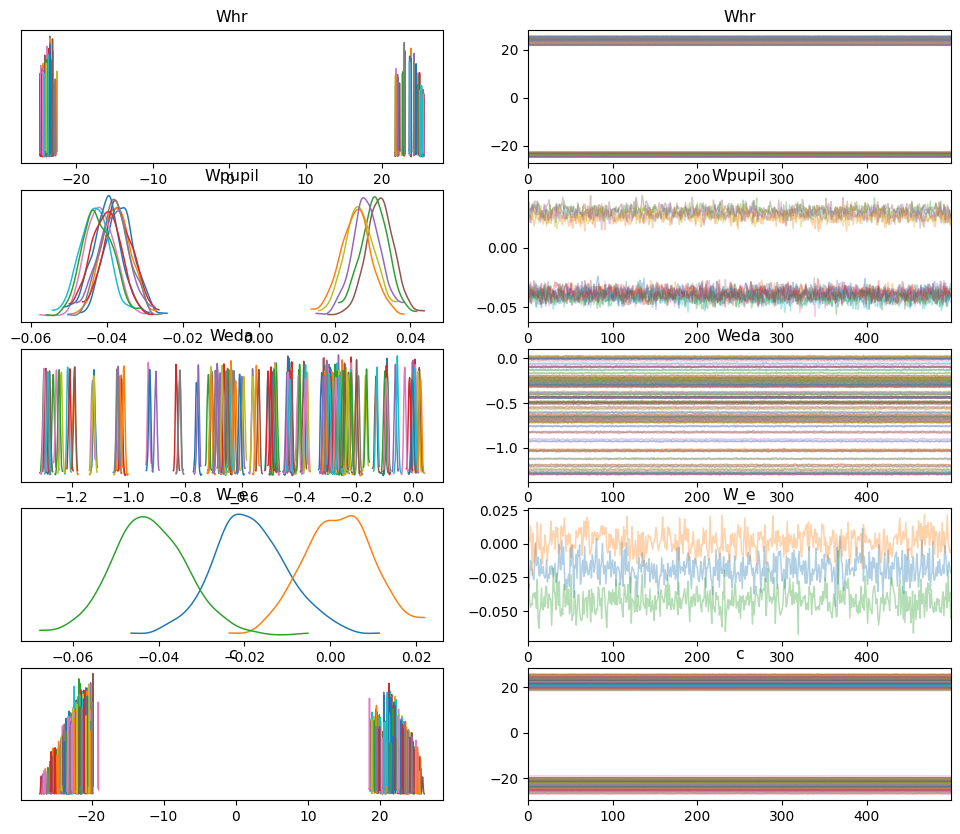

In [61]:
#az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen")
az.plot_trace(trace)
plt.show()

In [62]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"pupil_data": pupil,"hr_data":hr,"eda_data":eda})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)

Sampling: [x_e, x_eda, x_hr, x_pupil]


In [63]:
e_pred = posterior_predictive.posterior_predictive["x_e"]

In [64]:
e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:,np.newaxis]

In [65]:
e_pred_mode

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [66]:
e_labels

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
    

In [67]:
train_accuracy_exp = accuracy_score(e_labels, e_pred_mode)
print('\n\tTrain Accuracy Pain Expectation: ' + str(train_accuracy_exp))
print(' ')


	Train Accuracy Pain Expectation: 0.65625
 


--------------------------------------------------------------------------------------------

In [68]:
hr_pred_mean = (stats.median_abs_deviation(hr_pred[0]))[0]
hr_pred_mean

NameError: name 'hr_pred' is not defined

In [ ]:
hr[0]

In [ ]:
#hr_pred_mode= pd.Series([0.006,0.01,0.02,0.003])

hr and hr_pred_mode devono avere same shape

In [ ]:
train_accuracy_hr = (np.subtract(hr[0], hr_pred_mean))
print('\n\t avg distance hr: \n' + str(train_accuracy_hr))
#print(' ')

In [ ]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"hr_data": hr})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)
    gaze_pred = posterior_predictive.posterior_predictive["x_gaze"]

In [ ]:
gaze_pred

In [ ]:
gaze_pred_mean = np.mean(gaze_pred, axis=0).T.reshape(-1)
gaze_true = pupil.reshape(-1)
reconstructed_r2 = metrics.r2_score(gaze_true, gaze_pred_mean)

print('\n\tReconstructed X R2 score: ' + str(reconstructed_r2))

In [ ]:
import deepemogp.feature_extractor as feature_extractor

In [ ]:
f = feature_extractor.FE('wavelet', window=(8,6), params={'w_mother':'db3','w_maxlev':1})

In [ ]:
x = [3, 7, 1, 1, -2, 5, 4, 6]

In [ ]:
f.apply(x)